In [127]:
import torch
import sys
import numpy as np
from logistic_regression import *
from sklearn.metrics import f1_score, accuracy_score
from cage import *
from sklearn.feature_extraction.text import TfidfVectorizer
from losses import *
import pickle
from torch.utils.data import TensorDataset, DataLoader

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

torch.set_default_dtype(torch.float64)
torch.set_printoptions(threshold=20)

objs = []
n_classes = 2# int(sys.argv[11])
n_lfs = 73
dset_directory = "Data/SMS" #sys.argv[10]
with open(dset_directory + '/d_processed.p', 'rb') as f:
    while 1:
        try:
            o = pickle.load(f)
        except EOFError:
            break
        objs.append(o)

x_supervised = torch.tensor(objs[0]).double()
y_supervised = torch.tensor(objs[3]).long()
l_supervised = torch.tensor(objs[2]).long()
s_supervised = torch.tensor(objs[2]).double()

objs = []
with open(dset_directory + '/U_processed.p', 'rb') as f:
    while 1:
        try:
            o = pickle.load(f)
        except EOFError:
            break
        objs.append(o)

excl= []
idx=0
for x in objs[1]:
    if(all(x==int(n_classes))):
        excl.append(idx)
    idx+=1
print('no of excludings are ', len(excl))

x_unsupervised = torch.tensor(np.delete(objs[0],excl, axis=0)).double()
y_unsupervised = torch.tensor(np.delete(objs[3],excl, axis=0)).long()
l_unsupervised = torch.tensor(np.delete(objs[2],excl, axis=0)).long()
s_unsupervised = torch.tensor(np.delete(objs[2],excl, axis=0)).double()

print('Length of U is', len(x_unsupervised))

objs = []
with open(dset_directory + '/validation_processed.p', 'rb') as f:
    while 1:
        try:
            o = pickle.load(f)
        except EOFError:
            break
        objs.append(o)

x_valid = torch.tensor(objs[0]).double()
y_valid = objs[3]
l_valid = torch.tensor(objs[2]).long()
s_valid = torch.tensor(objs[2]).double()

objs1 = []
with open(dset_directory + '/test_processed.p', 'rb') as f:
    while 1:
        try:
            o = pickle.load(f)
        except EOFError:
            break
        objs1.append(o)
x_test = torch.tensor(objs1[0]).double()
y_test = objs1[3]
l_test = torch.tensor(objs1[2]).long()
s_test = torch.tensor(objs1[2]).double()


n_features = x_supervised.shape[1]

# Labeling Function Classes
# k = torch.from_numpy(np.array([0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0])).long()
#lf_classes_file = sys.argv[11]
k = torch.from_numpy(np.array([1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0])).long()
k = 1 - k
# k = torch.from_numpy(np.load(dset_directory + '/k.npy'))
# n_lfs = int(len(k))
print('number of lfs ', n_lfs)

continuous_mask = torch.zeros(n_lfs).double()


for i in range(s_supervised.shape[0]):
    for j in range(s_supervised.shape[1]):
        if s_supervised[i, j].item() > 0.999:
            s_supervised[i, j] = 0.999
        if s_supervised[i, j].item() < 0.001:
            s_supervised[i, j] = 0.001

for i in range(s_unsupervised.shape[0]):
    for j in range(s_unsupervised.shape[1]):
        if s_unsupervised[i, j].item() > 0.999:
            s_unsupervised[i, j] = 0.999
        if s_unsupervised[i, j].item() < 0.001:
            s_unsupervised[i, j] = 0.001

for i in range(s_valid.shape[0]):
    for j in range(s_valid.shape[1]):
        if s_valid[i, j].item() > 0.999:
            s_valid[i, j] = 0.999
        if s_valid[i, j].item() < 0.001:
            s_valid[i, j] = 0.001

for i in range(s_test.shape[0]):
    for j in range(s_test.shape[1]):
        if s_test[i, j].item() > 0.999:
            s_test[i, j] = 0.999
        if s_test[i, j].item() < 0.001:
            s_test[i, j] = 0.001



l = torch.cat([l_supervised, l_unsupervised])
s = torch.cat([s_supervised, s_unsupervised])
x_train = torch.cat([x_supervised, x_unsupervised])
y_train = torch.cat([y_supervised, y_unsupervised])
supervised_mask = torch.cat([torch.ones(l_supervised.shape[0]), torch.zeros(l_unsupervised.shape[0])])

no of excludings are  2721
Length of U is 1781
number of lfs  73


In [174]:
## Quality Guides ##

a = torch.ones(n_lfs).double() * 0.9
print('before ',a)
prec_lfs=[]
for i in range(n_lfs):
   correct = 0
   for j in range(len(y_valid)):
       if y_valid[j] == l_valid[j][i]:
           correct+=1
   prec_lfs.append(correct/len(y_valid))
a = torch.tensor(prec_lfs) 
## End Quality Quides##
# a =  torch.tensor(np.load(dset_directory + '/precision_values.npy'))
# print('after ',a)

#Setting |validation|=|supevised|
x_valid = x_valid[0:len(x_supervised)]
y_valid = y_valid[0:len(x_supervised)]
s_valid = s_valid[0:len(x_supervised)]
l_valid = l_valid[0:len(x_supervised)]

print(l_valid.shape)
print(l_valid[0])

before  tensor([0.9000, 0.9000, 0.9000,  ..., 0.9000, 0.9000, 0.9000])
torch.Size([69, 73])
tensor([0, 0, 0,  ..., 0, 0, 0])


In [175]:
a

tensor([0.8986, 0.8986, 0.8986,  ..., 0.8986, 0.8986, 0.8986])

In [176]:
a[50:73] = 0

In [177]:
num_runs = 1 #int(sys.argv[9])
# l1, l2,l3,l4,l5,l6,qg=True,True, False, False, False,False, False #L12
l1, l2,l3,l4,l5,l6,qg=True,True, True,True, True,True, True # L123456qg
# l1, l2,l3,l4,l5,l6,qg=True,True, True, True, True,True, True#L12346qg
# l1, l2,l3,l4,l5,l6,qg=False,False, False, False, True,False, True#L5qg
final_score_gm, final_score_lr, final_score_gm_val, final_score_lr_val = [],[],[],[]
for lo in range(0,num_runs):
    pi = torch.ones(n_classes, n_lfs).double()
    pi.requires_grad = True

    theta = torch.ones((n_classes, n_lfs)).double() * 1
    theta.requires_grad = True

    pi_y = torch.ones(n_classes).double()
    pi_y.requires_grad = True

    lr_model = LogisticRegression(n_features, n_classes)

    optimizer = torch.optim.Adam([{"params": lr_model.parameters()}, {"params": [pi, pi_y, theta]}], lr=0.003)
    optimizer_lr = torch.optim.Adam(lr_model.parameters(), lr=0.003)
    optimizer_gm = torch.optim.Adam([theta, pi, pi_y], lr=0.01, weight_decay=0)
    # optimizer = torch.optim.Adam([theta, pi, pi_y], lr=0.01, weight_decay=0)
    supervised_criterion = torch.nn.CrossEntropyLoss()



    dataset = TensorDataset(x_train, y_train, l, s, supervised_mask)

    loader = DataLoader(dataset, batch_size=32, shuffle=True,pin_memory=True)
#     save_folder = sys.argv[1]
    print('num runs are ', num_runs)
    best_score_lr,best_score_gm,best_epoch_lr,best_epoch_gm,best_score_lr_val, best_score_gm_val = 0,0,0,0,0,0
    stop_pahle, stop_pahle_gm = [], []

    for epoch in range(25):
        lr_model.train()

        for batch_ndx, sample in enumerate(loader):
            optimizer_lr.zero_grad()
            optimizer_gm.zero_grad()

            

            # Start entropy code
            # unsupervised_indices = (1-sample[4]).nonzero().squeeze()
            unsup = []
            sup = []
            # probs_graphical = probability(theta, pi_y, pi, sample[2][unsupervised_indices], \
            #     sample[3][unsupervised_indices], k, n_classes, continuous_mask)
            # probs_graphical = (probs_graphical.t() / probs_graphical.sum(1)).t()

            # ent = entropy_pre(probs_graphical)

            # sorts, indices  = torch.sort(ent)
            # indices = indices.tolist()
            # indices = indices[:int(len(indices)/2)]
            ## Finsished - entropy code

            # l = torch.cat([l_supervised, l_unsupervised[indices]])
            # s = torch.cat([s_supervised, s_unsupervised[indices]])
            # x_train = torch.cat([x_supervised, x_unsupervised[indices]])
            # y_train = torch.cat([y_supervised, y_unsupervised[indices]])
            # supervised_mask = torch.cat([torch.ones(l_supervised.shape[0]), torch.zeros(l_unsupervised[indices].shape[0])])

            supervised_indices = sample[4].nonzero().view(-1)
            # unsupervised_indices = indices  ## Uncomment for entropy
            unsupervised_indices = (1-sample[4]).nonzero().squeeze()


            if(l1):
                if len(supervised_indices) > 0:
                    loss_1 = supervised_criterion(lr_model(sample[0][supervised_indices]), sample[1][supervised_indices])
                else:
                    loss_1 = 0
            else:
                loss_1=0

            if(l2):
                unsupervised_lr_probability = torch.nn.Softmax()(lr_model(sample[0][unsupervised_indices]))
                loss_2 = entropy(unsupervised_lr_probability)
            else:
                loss_2=0
            if(l3):
                y_pred_unsupervised = np.argmax(probability(theta, pi_y, pi, sample[2][unsupervised_indices], sample[3][unsupervised_indices], k, n_classes,continuous_mask).detach().numpy(), 1)
                loss_3 = supervised_criterion(lr_model(sample[0][unsupervised_indices]), torch.tensor(y_pred_unsupervised))
            else:
                loss_3 = 0

            if (l4 and len(supervised_indices) > 0):
                loss_4 = log_likelihood_loss_supervised(theta, pi_y, pi, sample[1][supervised_indices], sample[2][supervised_indices], sample[3][supervised_indices], k, n_classes,
                                                        continuous_mask)
            else:
                loss_4 = 0

            if(l5):
                loss_5 = log_likelihood_loss(theta, pi_y, pi, sample[2][unsupervised_indices], sample[3][unsupervised_indices], k, n_classes, continuous_mask)
            else:
                loss_5 =0

            if(l6):
                if(len(supervised_indices) >0):
                    supervised_indices = supervised_indices.tolist()
                    probs_graphical = probability(theta, pi_y, pi, torch.cat([sample[2][unsupervised_indices], sample[2][supervised_indices]]),\
                    torch.cat([sample[3][unsupervised_indices],sample[3][supervised_indices]]), k, n_classes, continuous_mask)
                else:
                    probs_graphical = probability(theta, pi_y, pi,sample[2][unsupervised_indices],sample[3][unsupervised_indices],\
                         k, n_classes, continuous_mask)
                probs_graphical = (probs_graphical.t() / probs_graphical.sum(1)).t()
                probs_lr = torch.nn.Softmax()(lr_model(sample[0]))
                loss_6 = kl_divergence(probs_graphical, probs_lr)

            else:
                loss_6= 0
            # loss_6 = - torch.log(1 - probs_graphical * (1 - probs_lr)).sum(1).mean()
            if(qg):
                prec_loss = precision_loss(theta, k, n_classes, a)
            else:
                prec_loss =0

            loss = loss_1 + loss_2 + loss_3 + loss_4 + loss_6+loss_5 + 5*prec_loss
            # print('loss is',loss)
            if loss != 0:
                loss.backward()
                optimizer_gm.step()
                optimizer_lr.step()

        #print(lr_model.state_dict())
        #print(theta,pi)
        #Test
        y_pred = np.argmax(probability(theta, pi_y, pi, l_test, s_test, k, n_classes, continuous_mask).detach().numpy(), 1)
        gm_acc = f1_score(y_test, y_pred)
        #Valid
        y_pred = np.argmax(probability(theta, pi_y, pi, l_valid, s_valid, k, n_classes, continuous_mask).detach().numpy(), 1)
        gm_valid_acc = f1_score(y_valid, y_pred)
        # print(y_valid, y_pred)

        #LR Test

        probs = torch.nn.Softmax()(lr_model(x_test))
        y_pred = np.argmax(probs.detach().numpy(), 1)
        lr_acc =f1_score(y_test, y_pred)
        #LR Valid
        probs = torch.nn.Softmax()(lr_model(x_valid))
        y_pred = np.argmax(probs.detach().numpy(), 1)
        lr_valid_acc = f1_score(y_valid, y_pred)

        print("Epoch: {}\t Test GM accuracy_score: {}".format(epoch, gm_acc ))
        print("Epoch: {}\tGM accuracy_score(Valid): {}".format(epoch, gm_valid_acc))
        print("Epoch: {}\tTest LR accuracy_score: {}".format(epoch, lr_acc ))    
        print("Epoch: {}\tLR accuracy_score(Valid): {}".format(epoch, lr_valid_acc))
        

num runs are  1


/home/ayusham/.conda/envs/poincare/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/ayusham/.conda/envs/poincare/lib/python3.6/site-packages/ipykernel_launcher.py:107: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/ayusham/.conda/envs/poincare/lib/python3.6/site-packages/ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/ayusham/.conda/envs/poincare/lib/python3.6/site-packages/ipykernel_launcher.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 0	 Test GM accuracy_score: 0.17647058823529413
Epoch: 0	GM accuracy_score(Valid): 0.36363636363636365
Epoch: 0	Test LR accuracy_score: 0.7727272727272727
Epoch: 0	LR accuracy_score(Valid): 0.7272727272727273
Epoch: 1	 Test GM accuracy_score: 0.19999999999999998
Epoch: 1	GM accuracy_score(Valid): 0.5
Epoch: 1	Test LR accuracy_score: 0.7387387387387387
Epoch: 1	LR accuracy_score(Valid): 0.923076923076923
Epoch: 2	 Test GM accuracy_score: 0.19999999999999998
Epoch: 2	GM accuracy_score(Valid): 0.5
Epoch: 2	Test LR accuracy_score: 0.8541666666666667
Epoch: 2	LR accuracy_score(Valid): 0.923076923076923
Epoch: 3	 Test GM accuracy_score: 0.19999999999999998
Epoch: 3	GM accuracy_score(Valid): 0.5
Epoch: 3	Test LR accuracy_score: 0.8888888888888888
Epoch: 3	LR accuracy_score(Valid): 1.0
Epoch: 4	 Test GM accuracy_score: 0.19999999999999998
Epoch: 4	GM accuracy_score(Valid): 0.5
Epoch: 4	Test LR accuracy_score: 0.8775510204081632
Epoch: 4	LR accuracy_score(Valid): 1.0
Epoch: 5	 Test GM acc

In [162]:
pi[1].shape

torch.Size([73])

In [163]:
a

tensor([0., 0., 0.,  ..., 0., 0., 0.])

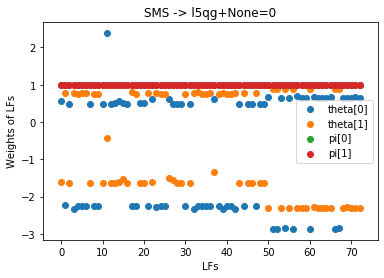

In [178]:
import matplotlib.pyplot as plt
plt.scatter(range(len(theta[0])), theta[0].detach().numpy(), label="theta[0]")
plt.scatter(range(len(theta[1])), theta[1].detach().numpy(), label="theta[1]")
plt.scatter(range(len(pi[0])), pi[0].detach().numpy(), label="pi[0]")
plt.scatter(range(len(pi[1])), pi[1].detach().numpy(), label="pi[1]")
plt.xlabel('LFs')
plt.ylabel('Weights of LFs')
plt.title('SMS -> l5qg+None=0')
plt.legend()

In [48]:
np.savetxt('np.txt', theta.detach().numpy())

In [ ]:
        if gm_valid_acc > best_score_gm_val and gm_valid_acc > best_score_lr_val:
            # print("Inside Best hu Epoch: {}\t Test GM accuracy_score: {}".format(epoch, gm_acc ))
            # print("Inside Best hu Epoch: {}\tGM accuracy_score(Valid): {}".format(epoch, gm_valid_acc))
            best_epoch_gm = epoch
            best_score_gm_val = gm_valid_acc
            best_score_gm = gm_acc
            best_epoch_lr = epoch
            best_score_lr_val = lr_valid_acc
            best_score_lr = lr_acc
            checkpoint = {'theta': theta,'pi': pi}
            torch.save(checkpoint, save_folder+"/gm_"+str(epoch)    +".pt")
            checkpoint = {'params': lr_model.state_dict()}
            torch.save(checkpoint, save_folder+"/lr_"+ str(epoch)+".pt")
            stop_pahle = []
            stop_pahle_gm = []

        if lr_valid_acc > best_score_lr_val and lr_valid_acc > best_score_gm_val:
            # print("Inside Best hu Epoch: {}\tTest LR accuracy_score: {}".format(epoch, lr_acc ))
            # print("Inside Best hu Epoch: {}\tLR accuracy_score(Valid): {}".format(epoch, lr_valid_acc))
            best_epoch_lr = epoch
            best_score_lr_val = lr_valid_acc
            best_score_lr = lr_acc
            best_epoch_gm = epoch
            best_score_gm_val = gm_valid_acc
            best_score_gm = gm_acc
            checkpoint = {'theta': theta,'pi': pi}
            torch.save(checkpoint, save_folder+"/gm_"+str(epoch)    +".pt")
            checkpoint = {'params': lr_model.state_dict()}
            torch.save(checkpoint, save_folder+"/lr_"+ str(epoch)+".pt")
            stop_pahle = []
            stop_pahle_gm = []


        if len(stop_pahle) >100 and len(stop_pahle_gm) >100 and (all(best_score_lr_val >= k for k in stop_pahle) or \
        all(best_score_gm_val >= k for k in stop_pahle_gm)):
            print('Early Stopping at', best_epoch_gm, best_score_gm, best_score_lr)
            print('Validation score Early Stopping at', best_epoch_gm, best_score_lr_val, best_score_gm_val)
            break
        else:
            # print('inside else stop pahle epoch', epoch)
            stop_pahle.append(lr_valid_acc)
            stop_pahle_gm.append(gm_valid_acc)

    # print("Run \t",lo, "Epoch Gm, Epoch LR, GM, LR \t", best_epoch_gm, best_epoch_lr,best_score_gm, best_score_lr)
    # print("Run \t",lo, "GM Val, LR Val \t", best_score_gm_val, best_score_lr_val)
    print("Run \t",lo, "Epoch, GM, LR \t",best_epoch_lr, best_score_gm, best_score_lr)
    print("Run \t",lo, "GM Val, LR Val \t", epoch, best_score_gm_val, best_score_lr_val)
    final_score_gm.append(best_score_gm)
    final_score_lr.append(best_score_lr)
    final_score_gm_val.append(best_score_gm_val)
    final_score_lr_val.append(best_score_lr_val)


print("Averaged scores are for GM,LR", np.sum(final_score_gm)/num_runs, np.sum(final_score_lr)/num_runs)
print("VALIDATION Averaged scores are for GM,LR", np.sum(final_score_gm_val)/num_runs, np.sum(final_score_lr_val)/num_runs)